## Evaluation Density Sampling on Real-World Data (DAMI)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats as sts
import scikit_posthocs as sph
sns.set(style="ticks", font_scale=1.25)

In [2]:
from eval_utils import *

In [3]:
OUR_METHOD_NAME = 'RAPID'

In [4]:
pd.options.display.max_columns = None
pd.options.display.precision = 4
pd.options.display.max_rows = 100
nan = np.nan
PLOT_PATH = '../plots'

In [5]:
df = load_results(['dami', 'dami_large', 'dami_baseline_rand', 'dami_baseline_prefiltering', 'dami_baseline_gt', 'dami_outperc', 'dami_large_outperc'])

In [6]:
print(f"Total computation time: {(df.time_sampling + df.svdd_reinit_ROT_C1_time_train + df.svdd_reinit_ROT_C1_time_pred).sum() / 60 / 60} hours.")

Total computation time: 189.8521569752625 hours.


Data set stats

In [7]:
d = df.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']]
d.describe()

,n_observations,outlier_ratio
count,23.0000,23.0000
mean,4911.4087,0.1790
std,10977.6054,0.1964
min,64.0000,0.0020
25%,197.2000,0.0355
50%,614.4000,0.0912
75%,3610.4000,0.2932
max,39627.2000,0.7538


Inspect exit codes

In [8]:
df.groupby(['sst', 'exit_code']).count()[['ss']]

ss
sst         exit_code                     
BPS         TooLargeSampleException     20
            success                    210
DAEDS       success                    230
DBSRSVDD    success                    230
FBPE        success                    230
HDS         TooLargeSampleException     10
            success                    105
HSR         success                    230
IESRSVDD    EmptySampleException         2
            success                    228
KFNCBD      success                    230
NDPSR       success                    230
PP_BPS      TooLargeSampleException     30
            success                    315
PP_DAEDS    success                    345
PP_DBSRSVDD EmptySampleException         4
            success                    341
PP_FBPE     success                    345
PP_HSR      success                    345
PP_IESRSVDD EmptySampleException         3
            success                    342
PP_KFNCBD   success                    345
PP_NDPSR    success                    345
RAPID       success                    345
Rand        TooLargeSampleException    760
            success                  13155

In [9]:
df.query('sst not in ["Rand", "HDS"] and exit_code == "TooLargeSampleException"')[['data_set_name', 'sst', 'sample_size', 'sample_ratio']]

,data_set_name,sst,sample_size,sample_ratio
hash,,,,
13068725566356945105,ALOI,PP_BPS,36815,0.9290
18193200259827727757,ALOI,PP_BPS,36810,0.9289
13899056995658486753,ALOI,BPS,37434,0.9446
8898982189133276177,ALOI,BPS,37418,0.9442
6479522191541045678,ALOI,BPS,37378,0.9433
5168342623672310827,ALOI,PP_BPS,36853,0.9300
11512728407021806767,ALOI,BPS,37481,0.9458
18029463157355858855,ALOI,PP_BPS,36790,0.9284
15038586484596807806,ALOI,BPS,37470,0.9456


BPS returned very large samples for ALOI and KDDCup99. In this case SVDD training runtimes become prohibitively long.

In [10]:
df['ss_threshold_strat'] = ['None' if x is np.nan or (type(x) == float and math.isnan(x)) else x for x in df['ss_threshold_strat']]

In [11]:
df_success = df.query('exit_code == "success"').sort_values('ss')

## Our method RAPID against competitors

Comparison values:

**Full:** SVDD fitted on the full data set. Note that parameter tuning is difficult. <br>
**Prefilter:** SVDD fitted on the data set after *pre-filtering*. We can then set C=1 and only have to tune $\gamma$.

In [12]:
target_threshold_strat = 'OutPerc(nothing)'

competitors_sst = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = [f'RAPID({target_threshold_strat})']

target_df = df.query('(sst in @competitors_sst or ss in @our_methods)').copy()

target_svdd_result = 'svdd_reinit_ROT_C1_mcc'#.replace('mcc', 'auc')
target_svdd_result_baseline = 'svdd_reinit_ROT_CTax_mcc'#.replace('mcc', 'auc')
target_svdd_result_ours = 'svdd_reinit_ROT_C1_mcc'#.replace('mcc', 'auc')
target_df['t_pred_1k'] = target_df[target_svdd_result.replace('mcc', 'time_pred')] / target_df['n_observations'] * 1000
mask = target_df.query('ss in @our_methods').index

In [13]:
d = target_df.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']]
d.columns = pd.MultiIndex.from_tuples([('stats', 'size'), ('stats', 'out_p')])

for s in competitors_sst:
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby('data_set_name').median()[['sample_ratio', target_svdd_result, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    x.columns = pd.MultiIndex.from_tuples([(s, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')
for s in our_methods:
    x = target_df.query('ss == @s').groupby('data_set_name').median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['Rand(1.0)']:
    x = df_success.query('scenario == "dami_baseline_gt"').groupby('data_set_name').median()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Full'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['HDS']:
    x = df_success.query('sst == @s and scenario == "dami_baseline_prefiltering"').groupby('data_set_name').median()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Prefilt'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

d = d.round(4)
d

stats          PP_BPS                 PP_DAEDS          \
                     size   out_p   ratio    svdd     pwc    ratio    svdd   
data_set_name                                                                
ALOI              39627.2  0.0304  0.9290     NaN     NaN   0.1844  0.0410   
Annthyroid         5703.2  0.0749  0.7736 -0.0172 -0.0325   0.1757 -0.0187   
Arrhythmia          360.0  0.4578  0.5417  0.3344  0.2992   0.1028  0.2936   
Cardiotocography   1691.2  0.2204  0.6507  0.3451  0.3413   0.1466  0.3439   
Glass               171.2  0.0421  0.4561 -0.0341 -0.0341   0.1813 -0.0341   
HeartDisease        216.0  0.4444  0.5509  0.2750  0.2362   0.1065  0.2740   
Hepatitis            64.0  0.1625  0.8281  0.1816  0.3333   0.1562  0.0000   
InternetAds        1572.8  0.1872  0.8130  0.1290  0.2267   0.1476  0.0556   
Ionosphere          280.8  0.3590  0.4377  0.5119  0.3866   0.1139  0.5384   
KDDCup99          38490.4  0.0042  0.9195     NaN     NaN   0.1885  0.3501   
Lymphography        118.4  0.0405  0.2966  0.4734  0.6948   0.1780  0.2004   
PageBlocks         4314.4  0.0946  0.5359  0.4190  0.3962   0.1713  0.4121   
Parkinson           156.0  0.7538  0.2436 -0.0050 -0.0722   0.0385 -0.0876   
PenDigits          7894.4  0.0020  0.6913  0.0000  0.0000   0.1885  0.0000   
Pima                614.4  0.3490  0.4544  0.2453  0.2658   0.1254  0.2522   
Shuttle             810.4  0.0128  0.4667 -0.0122 -0.0086   0.1840 -0.0122   
SpamBase           3365.6  0.3991  0.5986  0.0581  0.0527   0.1147  0.0461   
Stamps              272.0  0.0912  0.4228  0.3630  0.2359   0.1654  0.3269   
WBC                 178.4  0.0448  0.7360  0.5025  0.6988   0.1854  0.5498   
WDBC                293.6  0.0272  0.9150  0.4476  0.7022   0.1741  0.4784   
WPBC                158.4  0.2374  0.7547  0.0000 -0.0436   0.1519 -0.0580   
Waveform           2754.4  0.0290  0.9706  0.0615  0.0564   0.1823  0.0589   
Wilt               3855.2  0.0533  0.2198 -0.0593 -0.0542   0.1793 -0.0593   

                         PP_DBSRSVDD                 PP_FBPE                  \
                     pwc       ratio    svdd     pwc   ratio    svdd     pwc   
data_set_name                                                                  
ALOI              0.0383      0.0106  0.0357  0.0434  0.0010  0.0392  0.0333   
Annthyroid       -0.0315      0.0030 -0.0048  0.0092  0.0082 -0.0264 -0.0353   
Arrhythmia        0.3370      0.5028  0.3344  0.3497  0.0917  0.2409  0.3344   
Cardiotocography  0.3718      0.0142  0.3681  0.4443  0.0254  0.3556  0.2155   
Glass            -0.0341      0.1287 -0.0801 -0.0341  0.2339 -0.0488 -0.0341   
HeartDisease      0.0830      0.0278  0.0542 -0.0316  0.1991  0.1195 -0.0091   
Hepatitis         0.1240      0.6406  0.1240  0.3671  0.4688  0.1816  0.2774   
InternetAds       0.0465      0.3933  0.0755  0.1470  0.0159  0.0000  0.0000   
Ionosphere        0.4992      0.1246  0.4244  0.4021  0.1429  0.5454  0.5847   
KDDCup99          0.3775      0.0057  0.1966  0.2327  0.0010  0.0826  0.3568   
Lymphography      0.2883      0.0508  0.3062  0.6944  0.2203  0.4734  0.6948   
PageBlocks        0.4250      0.0035  0.4514  0.4336  0.0107  0.4355  0.2910   
Parkinson         0.0314      0.2436 -0.0050 -0.0722  0.1603 -0.0759 -0.0495   
PenDigits         0.0000      0.0004  0.0000  0.0000  0.0051  0.0000  0.0000   
Pima              0.2716      0.0912  0.1907  0.1062  0.0715  0.2576  0.1980   
Shuttle          -0.0150      0.0049  0.0544  0.0393  0.0481 -0.0122 -0.0086   
SpamBase          0.0218      0.2681  0.0521  0.0085  0.0095  0.0685  0.0632   
Stamps            0.3375      0.0551  0.1866  0.2527  0.1728  0.3630  0.1110   
WBC               0.6988      0.1966  0.5498  0.6988  0.1899  0.5498  0.6988   
WDBC              0.6972      0.2789  0.4784  0.7022  0.1361  0.3610  0.6191   
WPBC             -0.0970      0.5633 -0.1179 -0.0808  0.2264 -0.0292 -0.0429   
Waveform          0.0307      0.1362  0.0615  0.0614  0.0167  0.0033 -0

### Model quality

In [14]:
mcc_mask = d.columns.get_level_values(1) == 'svdd'
d_highlight = d.iloc[:, mcc_mask].copy()
ranks = d_highlight.rank(axis=1, method='min', ascending=False, na_option='bottom')
d_highlight.loc['MEDIAN'] = d_highlight.median(skipna=False)
d_highlight.loc['AVG RANK'] = ranks.mean()
d_highlight.style.apply(highlight_max, axis=1)

,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,RAPID,Full,Prefilt
,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd
data_set_name,,,,,,,,,,,
ALOI,nan,0.0410,0.0357,0.0392,0.0306,0.0416,0.0412,0.0375,0.0420,nan,nan
Annthyroid,-0.0172,-0.0187,-0.0048,-0.0264,-0.0316,-0.0162,-0.0153,-0.0300,-0.0169,0.0205,-0.0179
Arrhythmia,0.3344,0.2936,0.3344,0.2409,0.0000,0.3344,0.3067,0.3344,0.3256,0.2900,0.3344
Cardiotocography,0.3451,0.3439,0.3681,0.3556,0.3542,0.3451,0.3537,0.3446,0.3359,0.1494,0.3428
Glass,-0.0341,-0.0341,-0.0801,-0.0488,-0.0341,-0.3179,-0.2017,-0.0488,-0.0488,-0.0574,-0.0698
HeartDisease,0.2750,0.2740,0.0542,0.1195,0.2750,0.2325,-0.2096,0.2000,0.2325,0.0791,0.2750
Hepatitis,0.1816,0.0000,0.1240,0.1816,0.1816,0.1240,0.0000,0.1429,0.1429,0.1816,0.1816
InternetAds,0.1290,0.0556,0.0755,0.0000,0.0000,0.1290,0.0243,0.1215,0.1215,0.1314,0.1290


### Ratio

In [15]:
mcc_mask = d.columns.get_level_values(1) == 'ratio'
d_highlight = d.iloc[:, mcc_mask].copy()
ranks = d_highlight.rank(axis=1, method='min', ascending=True, na_option='bottom')
d_highlight.loc['MEDIAN'] = d_highlight.median()
d_highlight.loc['AVG RANK'] = ranks.mean()
d_highlight.style.apply(highlight_min, axis=1)

,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,RAPID,Full,Prefilt
,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio,ratio
data_set_name,,,,,,,,,,,
ALOI,0.9290,0.1844,0.0106,0.0010,0.0010,0.0777,0.1939,0.0250,0.0005,nan,nan
Annthyroid,0.7736,0.1757,0.0030,0.0082,0.0188,0.3728,0.1850,0.0135,0.0077,1.0000,0.9251
Arrhythmia,0.5417,0.1028,0.5028,0.0917,0.0028,0.3722,0.1083,0.4833,0.1194,1.0000,0.5417
Cardiotocography,0.6507,0.1466,0.0142,0.0254,0.3950,0.3712,0.1555,0.1017,0.0171,1.0000,0.7796
Glass,0.4561,0.1813,0.1287,0.2339,0.4620,0.1988,0.1871,0.2164,0.0351,1.0000,0.9591
HeartDisease,0.5509,0.1065,0.0278,0.1991,0.5509,0.2963,0.1111,0.0417,0.1019,1.0000,0.5556
Hepatitis,0.8281,0.1562,0.6406,0.4688,0.8281,0.6250,0.1562,0.6719,0.5000,1.0000,0.8438
InternetAds,0.8130,0.1476,0.3933,0.0159,0.0006,0.7697,0.1622,0.6985,0.5216,1.0000,0.8130


### Statistical Analysis

In [16]:
hyptest_kwargs = {'linewidths': 1, 'linecolor': '1.0', 'cmap': ['1', '#cccccc',  '#000000', '#08306b',  '#4292c6']}
d_tests = []
for s in our_methods:
    t_col = ['data_set_name', 'fold', 'time_sampling', f'{target_svdd_result_ours[:-4]}_time_train', f'{target_svdd_result_ours[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result_ours[:-4]}_num_support_vectors', target_svdd_result_ours, 'pwc_mcc']
    x = target_df.query('ss == @s')[t_col].reset_index(drop=True)
    x.columns = ['data_set_name', 'fold', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    d_tests.append(x[['data_set_name', 'fold', 'ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
for s in competitors_sst:
    t_col = ['data_set_name', 'fold', 'time_sampling', f'{target_svdd_result[:-4]}_time_train', f'{target_svdd_result[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result[:-4]}_num_support_vectors', target_svdd_result, 'pwc_mcc']
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]')[t_col]
    x.columns = ['data_set_name', 'fold', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s
    d_tests.append(x[['data_set_name', 'fold', 'ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
d_tests = pd.concat(d_tests).reset_index(drop=True)
d_tests.ss = d_tests.ss.str.replace('PP_', '')

def run_hyptest(data, metric='svdd', name='quality'):
    d_test = data.pivot(index=['data_set_name', 'fold'], columns='ss', values=metric)
    print(sts.friedmanchisquare(*d_test.T.values))
    x = sph.posthoc_nemenyi_friedman(d_test.reset_index(drop=True))
    fig, ax = plt.subplots()
    sph.sign_plot(x, ax=ax, **hyptest_kwargs)
    fig.savefig(os.path.join(PLOT_PATH, f"eval_dami_hyptest_{name}.pdf"), bbox_inches='tight')
    return x

#### SVDD quality

FriedmanchisquareResult(statistic=50.00054960153857, pvalue=4.085765209391831e-08)


,BPS,DAEDS,DBSRSVDD,FBPE,HSR,IESRSVDD,KFNCBD,NDPSR,RAPID
BPS,1.0000,0.0479,0.0010,0.7290,0.0782,0.7973,0.0273,0.5975,0.9000
DAEDS,0.0479,1.0000,0.9000,0.8814,0.9000,0.8130,0.9000,0.9000,0.1810
DBSRSVDD,0.0010,0.9000,1.0000,0.1532,0.8887,0.1164,0.9000,0.2476,0.0036
FBPE,0.7290,0.8814,0.1532,1.0000,0.9000,0.9000,0.7718,0.9000,0.9000
HSR,0.0782,0.9000,0.8887,0.9000,1.0000,0.9000,0.9000,0.9000,0.2601
IESRSVDD,0.7973,0.8130,0.1164,0.9000,0.9000,1.0000,0.7035,0.9000,0.9000
KFNCBD,0.0273,0.9000,0.9000,0.7718,0.9000,0.7035,1.0000,0.9000,0.1177
NDPSR,0.5975,0.9000,0.2476,0.9000,0.9000,0.9000,0.9000,1.0000,0.9000
RAPID,0.9000,0.1810,0.0036,0.9000,0.2601,0.9000,0.1177,0.9000,1.0000


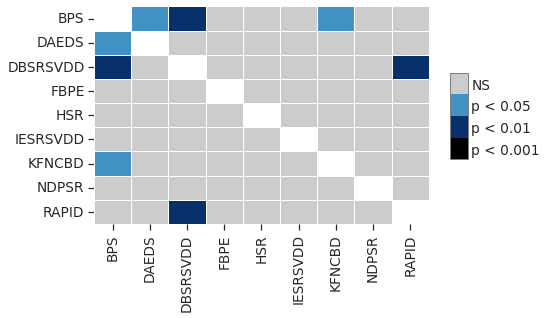

In [17]:
run_hyptest(d_tests, 'svdd', 'quality')

#### Sampling Ratio

FriedmanchisquareResult(statistic=423.0991489052156, pvalue=2.135234431870131e-86)


,BPS,DAEDS,DBSRSVDD,FBPE,HSR,IESRSVDD,KFNCBD,NDPSR,RAPID
BPS,1.000,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
DAEDS,0.001,1.0000,0.9000,0.6257,0.0010,0.0010,0.1214,0.0012,0.0010
DBSRSVDD,0.001,0.9000,1.0000,0.9000,0.0010,0.0010,0.0013,0.0010,0.0037
FBPE,0.001,0.6257,0.9000,1.0000,0.0010,0.0010,0.0010,0.0010,0.0241
HSR,0.001,0.0010,0.0010,0.0010,1.0000,0.9000,0.1003,0.8375,0.0010
IESRSVDD,0.001,0.0010,0.0010,0.0010,0.9000,1.0000,0.6403,0.9000,0.0010
KFNCBD,0.001,0.1214,0.0013,0.0010,0.1003,0.6403,1.0000,0.9000,0.0010
NDPSR,0.001,0.0012,0.0010,0.0010,0.8375,0.9000,0.9000,1.0000,0.0010
RAPID,0.001,0.0010,0.0037,0.0241,0.0010,0.0010,0.0010,0.0010,1.0000


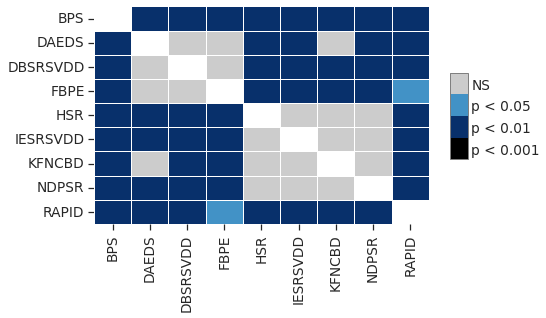

In [18]:
run_hyptest(d_tests, 'ratio', 'ratio')

#### Sampling Time

FriedmanchisquareResult(statistic=358.24695652173887, pvalue=1.5713098756606467e-72)


,BPS,DAEDS,DBSRSVDD,FBPE,HSR,IESRSVDD,KFNCBD,NDPSR,RAPID
BPS,1.0000,0.9000,0.0010,0.0010,0.001,0.0010,0.8448,0.3067,0.0010
DAEDS,0.9000,1.0000,0.0010,0.0010,0.001,0.0010,0.9000,0.0271,0.0010
DBSRSVDD,0.0010,0.0010,1.0000,0.0010,0.001,0.0010,0.0010,0.0010,0.0085
FBPE,0.0010,0.0010,0.0010,1.0000,0.900,0.5818,0.0010,0.0317,0.1177
HSR,0.0010,0.0010,0.0010,0.9000,1.000,0.9000,0.0010,0.0010,0.9000
IESRSVDD,0.0010,0.0010,0.0010,0.5818,0.900,1.0000,0.0010,0.0010,0.9000
KFNCBD,0.8448,0.9000,0.0010,0.0010,0.001,0.0010,1.0000,0.0037,0.0010
NDPSR,0.3067,0.0271,0.0010,0.0317,0.001,0.0010,0.0037,1.0000,0.0010
RAPID,0.0010,0.0010,0.0085,0.1177,0.900,0.9000,0.0010,0.0010,1.0000


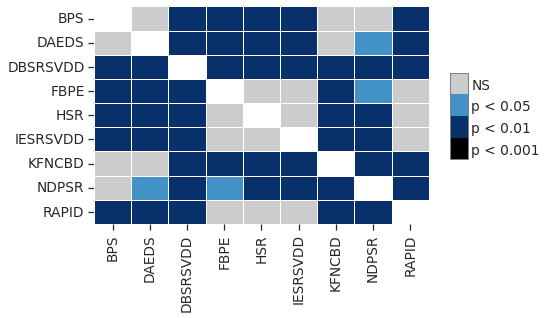

In [19]:
run_hyptest(d_tests, 't_samp', 'sample_time')

---

### Additional stats for top methods

In [20]:
stats = d_tests.groupby(['ss', 'data_set_name']).median().reset_index().groupby('ss').median()
stats.insert(3, 't_tot', stats[['t_samp', 't_train', 't_pred']].sum(axis=1))
stats = stats[['t_samp', 't_train', 't_pred', 'size', 'ratio', 'svdd']]
stats.round(2)
#print(stats.round(2).to_latex())

,t_samp,t_train,t_pred,size,ratio,svdd
ss,,,,,,
BPS,0.08,0.29,0.01,279.0,0.60,0.18
DAEDS,0.35,0.03,0.00,77.0,0.17,0.06
DBSRSVDD,0.01,0.02,0.00,35.0,0.09,0.08
FBPE,0.04,0.02,0.00,40.0,0.07,0.08
HSR,0.12,0.04,0.00,111.0,0.40,0.06
IESRSVDD,0.01,0.05,0.00,127.0,0.22,0.13
KFNCBD,0.27,0.03,0.00,80.0,0.18,0.04
NDPSR,0.04,0.04,0.00,87.0,0.23,0.14
RAPID,0.01,0.02,0.00,18.0,0.04,0.14


In [21]:
d_tests.groupby(['ss', 'data_set_name']).mean().reset_index().groupby('ss').count()

,data_set_name,fold,t_samp,t_train,t_pred,size,ratio,SVs,svdd,pwc
ss,,,,,,,,,,
BPS,23,23,23,21,21,23,23,21,21,21
DAEDS,23,23,23,23,23,23,23,23,23,23
DBSRSVDD,23,23,23,23,23,23,23,23,23,23
FBPE,23,23,23,23,23,23,23,23,23,23
HSR,23,23,23,23,23,23,23,23,23,23
IESRSVDD,23,23,23,23,23,23,23,23,23,23
KFNCBD,23,23,23,23,23,23,23,23,23,23
NDPSR,23,23,23,23,23,23,23,23,23,23
RAPID,23,23,23,23,23,23,23,23,23,23


BPS produced prohibitively large samples (>40k observations) on the ALOI and KDDCup99 data set. The median is therefore missleading and we report it as NaN.

Overview results with **mean** aggregation:

In [22]:
stats = d_tests.groupby(['ss', 'data_set_name']).mean().reset_index().groupby('ss').mean()
stats.insert(3, 't_tot', stats[['t_samp', 't_train', 't_pred']].sum(axis=1))
stats = stats[['t_samp', 't_train', 't_pred', 'size', 'ratio', 'svdd']]
stats.round(2)
#print(stats.round(2).to_latex())

,t_samp,t_train,t_pred,size,ratio,svdd
ss,,,,,,
BPS,6.04,59.59,0.40,4098.42,0.62,0.21
DAEDS,32.58,289.06,1.34,886.85,0.15,0.18
DBSRSVDD,6.38,0.43,0.14,139.64,0.17,0.16
FBPE,2.25,0.02,0.02,38.14,0.11,0.18
HSR,3.00,62.16,0.24,584.32,0.39,0.18
IESRSVDD,17.30,222.89,1.42,1071.92,0.30,0.18
KFNCBD,24.74,357.23,2.33,935.78,0.16,0.16
NDPSR,10.01,1.72,0.25,266.00,0.26,0.20
RAPID,4.73,46.11,0.21,397.58,0.12,0.21


RAPID mean values for t_samp, t_train, size and ratio are higher because RAPID returns a very large sample for only one data set (PenDigits). RAPID performs better than the competitors (BPS numbers are again misleading, see previous comment).

### Comparison against full data set

In [23]:
d_prefit = df_success.query('scenario == "dami_baseline_prefiltering"')

In [24]:
d_prefit[['sample_size', 'svdd_time_train']].describe()

,sample_size,svdd_time_train
count,105.0000,105.0000
mean,1471.5048,234.6582
std,2067.1672,521.9090
min,38.0000,0.0275
25%,164.0000,0.1408
50%,286.0000,0.5578
75%,2023.0000,166.2198
max,7889.0000,2244.5750


Quality deviation of RAPID compared to SVDD trained after the pre-filtering.

In [25]:
(d[[('RAPID', 'svdd')]].values - d[[('Prefilt', 'svdd')]]).describe()

,Prefilt
,svdd
count,21.0000
mean,-0.0051
std,0.0338
min,-0.1004
25%,-0.0084
50%,0.0000
75%,0.0010
max,0.0937


Classification quality after the prefiltering step

In [26]:
x = df_success.query('sst == "HDS" and scenario == "dami_baseline_prefiltering"').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', 'svdd_reinit_ROT_C1_mcc', 'pwc_mcc']].reset_index()
x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
x[['sst', 'data', 'ratio', 'svdd', 'pwc']]

,sst,data,ratio,svdd,pwc
0,HDS,Annthyroid,0.9251,-0.0172,-0.0337
1,HDS,Arrhythmia,0.5417,0.3344,0.2992
2,HDS,Cardiotocography,0.7796,0.3451,0.3611
3,HDS,Glass,0.9591,-0.0488,-0.0341
4,HDS,HeartDisease,0.5556,0.2750,0.2362
5,HDS,Hepatitis,0.8438,0.1816,0.3333
6,HDS,InternetAds,0.8130,0.1290,0.2267
7,HDS,Ionosphere,0.6406,0.5119,0.3801
8,HDS,Lymphography,0.9580,0.4734,0.6948
9,HDS,PageBlocks,0.9054,0.4190,0.4295


---

### Plot

In [27]:
target_threshold_strat = 'OutPerc(nothing)'

competitors_sst = ['BPS', 'DAEDS', 'DBSRSVDD', 'FBPE', 'HSR', 'IESRSVDD', 'KFNCBD', 'NDPSR']
competitors_sst_pp = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = [f'RAPID({target_threshold_strat})']

target_df = df_success.query('(sst in @competitors_sst or sst in @competitors_sst_pp or ss in @our_methods)').copy()

target_svdd_result = 'svdd_reinit_ROT_CTax_mcc'
target_svdd_result_pp = 'svdd_reinit_ROT_C1_mcc'
target_svdd_result_baseline = 'svdd_reinit_ROT_CTax_mcc'
target_svdd_result_baseline_full = 'svdd_mcc'
target_svdd_result_ours = 'svdd_reinit_ROT_C1_mcc'

In [28]:
d_plot = []
for s in competitors_sst:
    x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    d_plot.append(x)
    
for s in competitors_sst_pp:
    x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_pp, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    d_plot.append(x)

for s in ['Rand']:
    x = df_success.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_baseline, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    d_plot.append(x)

for s in ['Rand(1.0)']:
    x = df_success.query('ss == @s and scenario == "dami_baseline_gt" and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_baseline_full, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    x.ss = 'Full'
    d_plot.append(x)
    
for s in ['HDS']:
    x = df_success.query('sst == @s and scenario == "dami_baseline_prefiltering"').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_pp, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    d_plot.append(x)

for s in our_methods:
    x = target_df.query('ss == @s').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc', 'time_sampling', target_svdd_result.replace('mcc', 'time_train'), target_svdd_result.replace('mcc', 'time_pred')]].reset_index()
    x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc', 't_samp', 't_train', 't_class']
    d_plot.append(x)

d_plot = pd.concat(d_plot).set_index('data')
d_plot['removed'] = 1 - d_plot['ratio']
y = df_success.groupby('data_set_name')[['n_dims', 'n_observations']].max().reset_index()
y.columns = ['data', 'M', 'N']
d_plot = d_plot.join(y.set_index('data'))
d_plot.reset_index(inplace=True)

In [29]:
markers = {}
filled_markers = ('o', 'v', 'p', 'D', 'P', 'X', '^', '<', '*', '>')
for i, s in enumerate(competitors_sst):
    markers[s] = filled_markers[i]
markers['RAPID'] = 's'

### Avg over all data sets

In [30]:
colorpalette = sns.cubehelix_palette(8, start=2.666, rot=-.01, light=0.7) + [(0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

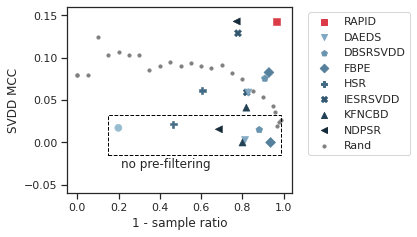

In [31]:
sns.set(style="ticks", font_scale=1.0, rc={'figure.figsize':(6, 3.5)})
d_plot_all = d_plot.query('sst not in ["HDS", "Rand", "PP_BPS"]').groupby(['sst']).median().reset_index()
d_plot_all.sst = d_plot_all.sst.str.replace('PP_', '')
f = sns.scatterplot(data=d_plot_all, x='removed', y='svdd', hue='sst', style='sst', hue_order=[x for x in markers.keys() if x in d_plot_all.sst.values], markers=markers, s=50, edgecolor=None, palette=colorpalette)
x = d_plot.query('sst == "Rand"').groupby('ss').median()
plt.scatter(x['removed'], x['svdd'], color='grey', alpha=1, label="Rand", s=10)

handles, labels = f.axes.get_legend_handles_labels()
plt.legend(handles=[handles[-2]] + handles[1:-2] + [handles[-1]], labels=[OUR_METHOD_NAME] + labels[1:-2] + [labels[-1]], bbox_to_anchor=(1.05, 1), loc=0, title=None)
eps_x, eps_y = 0.05, 0.015
top_left_box_p = d_plot_all.query('sst == "BPS"').min()
bot_right_box_p_x = d_plot_all.query('sst == "FBPE" and removed > 0.9')
bot_right_box_p_y = d_plot_all.query('sst == "FBPE" and removed > 0.9')
box_x_min, box_x_max = top_left_box_p.removed  - eps_x, bot_right_box_p_x.removed.values[0]  + eps_x
box_y_min, box_y_max = bot_right_box_p_y.svdd.values[0]  - eps_y, top_left_box_p.svdd  + eps_y
r = Rectangle((box_x_min, box_y_min), box_x_max - box_x_min, box_y_max - box_y_min,
              fill=False, linestyle='dashed', color='black')
f.axes.add_patch(r)
plt.text((box_x_max - box_x_min) * 0.25, -0.03, 'no pre-filtering')
plt.tight_layout()
plt.ylim(-0.06, 0.16)
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([-0.05, 0.0, 0.05, 0.1, 0.15])
plt.xlabel('1 - sample ratio')
plt.ylabel('SVDD MCC')
plt.savefig(os.path.join(PLOT_PATH, f"eval_avg.pdf"))
plt.savefig(os.path.join(PLOT_PATH, f"eval_avg.png"), dpi=300)

### Results per data set

In [32]:
sns.set(style="ticks", font_scale=1.35)

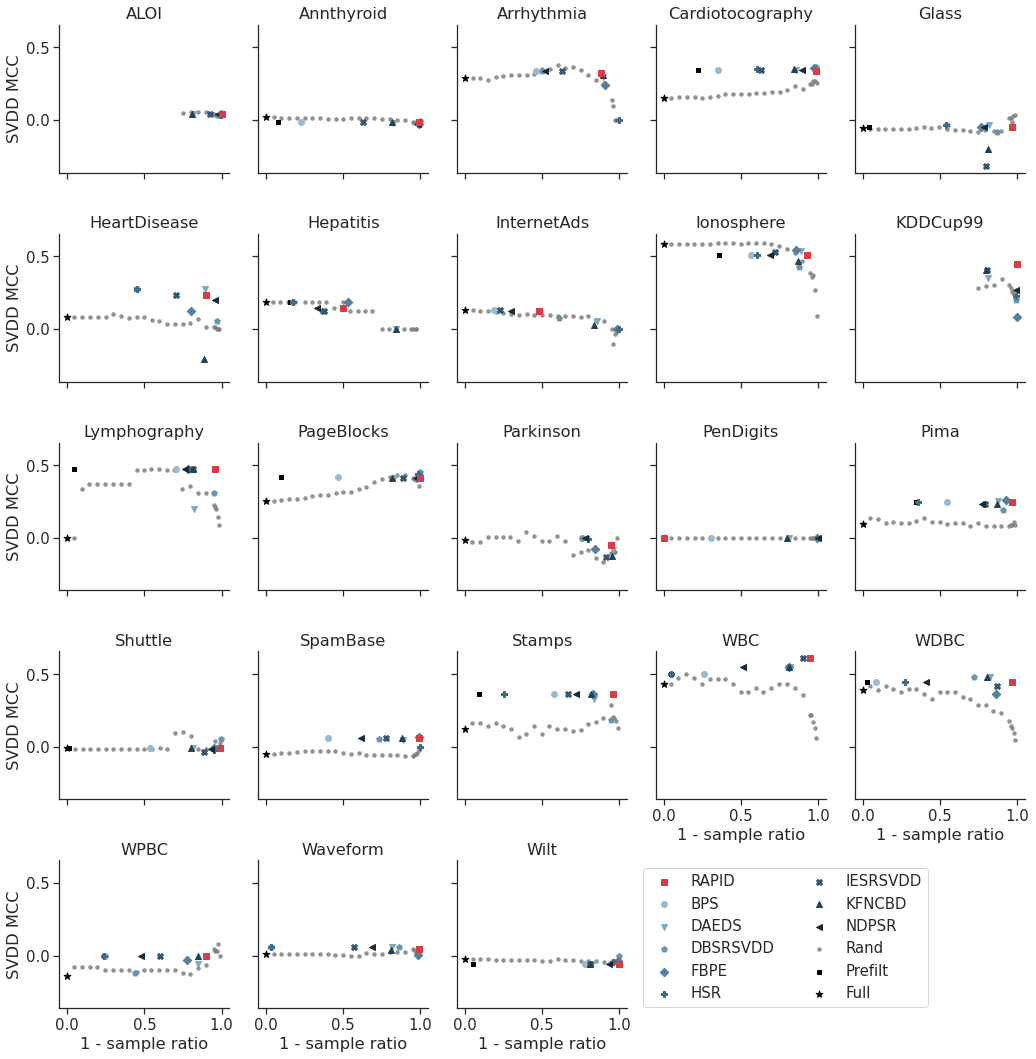

In [33]:
x = d_plot.query('sst in @competitors_sst_pp or sst == @OUR_METHOD_NAME').copy()
x.sst = x.sst.str.replace('PP_', '')
f = sns.FacetGrid(x, col='data', col_wrap=5, col_order=sorted(d_plot.data.unique()), hue='sst', hue_order=markers.keys(), hue_kws=dict(marker=list(markers.values())), legend_out=False, palette=colorpalette)
for idx, data_name in enumerate(sorted(f.col_names)):
    x = d_plot.query('sst == "Rand" and removed > 0.0 and data == @data_name')
    f.axes[idx].scatter(x['removed'], x['svdd'], color='grey', alpha=.8, label="Rand", s=12)
    x = d_plot.query('sst == "HDS" and data == @data_name')
    f.axes[idx].scatter(x['removed'], x['svdd'], color='black', alpha=1, label="Prefilt", s=15, marker='s')
    x = d_plot.query('ss == "Full" and data == @data_name')
    f.axes[idx].scatter(x['removed'], x['svdd'], color='black', alpha=1, label="Full", s=50, marker='*')

f.map(plt.scatter, "removed", 'svdd')
f.set_titles('{col_name}')
f.set_axis_labels('1 - sample ratio', 'SVDD MCC')
handles, labels = f.axes[3].get_legend_handles_labels()
plt.legend(handles=[handles[-1]] + handles[3:-1] + handles[0:3], labels=[OUR_METHOD_NAME] + labels[3:-1] + labels[0:3], bbox_to_anchor=(1.05, 1), loc=0, title=None, ncol=2)
plt.savefig(os.path.join(PLOT_PATH, f"eval_per_dataset.pdf"))
plt.savefig(os.path.join(PLOT_PATH, f"eval_per_dataset.png"), dpi=300)

## Sampling runtime

In [34]:
hue_order=[x for x in markers.keys() if x in d_plot_all.sst.values]
f_dashes = ('-', '--', '-.', ':')
colorpalette = sns.cubehelix_palette(8, start=2.666, rot=-.01, light=0.7) + [(0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]
kwargs = {'hue': 'sst', 'hue_order': hue_order, 'err_style': None, 'legend': None,
          'style': 'sst', 'dashes': False, 'markers': markers, 'palette': colorpalette, 'markeredgewidth': 0, 'markersize': 8}
kwargs_leg = {**kwargs, 'legend': 'full'}
sns.set(style="ticks", font_scale=1.0, rc={'figure.figsize':(7, 3.5)})

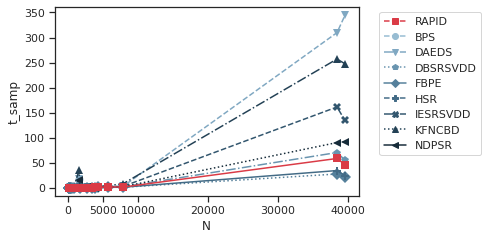

In [35]:
x = d_plot.query('sst in @competitors_sst_pp or sst == @OUR_METHOD_NAME').groupby(['sst', 'data']).median().reset_index()
x.sst = x.sst.str.replace('PP_', '')
f = sns.lineplot(data=x, x='N', y='t_samp', **kwargs_leg)
for i, l in enumerate(f.axes.lines):
    l.set_linestyle(f_dashes[i % len(f_dashes)])
f.axes.legend()
handles, labels = f.axes.get_legend_handles_labels()
plt.legend(handles=[handles[-1]] + handles[0:-1], labels=[OUR_METHOD_NAME] + labels[0:-1], bbox_to_anchor=(1.05, 1), loc=0, title=None)
plt.xlabel('N')
plt.xticks([0, 5000, 10000, 20000, 30000, 40000])
plt.ylabel('t_samp')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f"eval_sampling_runtime.pdf"))
plt.savefig(os.path.join(PLOT_PATH, f"eval_sampling_runtime.png"), dpi=300)

In [36]:
y = x.query('N > 20000').sort_values('data')[['sst', 'data', 't_samp', 't_train', 't_class', 'ratio', 'svdd']].set_index(['data', 'sst'])
y.round(4)
#print(y.round(4).to_latex())

t_samp    t_train  t_class   ratio    svdd
data     sst                                                   
ALOI     DAEDS     344.2817  3847.4930  13.1636  0.1844  0.0410
         DBSRSVDD   55.0896     0.7726   0.9503  0.0106  0.0357
         FBPE       21.1945     0.0198   0.4990  0.0010  0.0392
         HSR        24.0747     0.0204   0.1129  0.0010  0.0306
         IESRSVDD  134.3110   296.5463   8.7749  0.0777  0.0416
         KFNCBD    247.4868  4607.4732  12.9629  0.1939  0.0412
         NDPSR      92.1190     8.3500   2.5350  0.0250  0.0375
         RAPID      45.8714     0.0184   0.0638  0.0005  0.0420
KDDCup99 DAEDS     309.7272  3865.6893  14.6692  0.1885  0.3501
         DBSRSVDD   70.2679     0.1531   0.5541  0.0057  0.1966
         FBPE       27.3335     0.0207   0.4622  0.0010  0.0826
         HSR        34.2100     0.2661   0.5596  0.0069  0.2296
         IESRSVDD  161.1876  3969.8312  17.6572  0.1913  0.4056
         KFNCBD    256.9911  4591.3423  16.2102  0.1992  0.4025
         NDPSR      90.1258     0.1127   0.4317  0.0050  0.2667
         RAPID      58.3369     0.0229   0.1312  0.0013  0.4501

Helper

In [37]:
sns.set(style="ticks", font_scale=1.35)

def avg_plot(target_threshold_strat, metric='mcc'):
    target_svdd_result = f'svdd_reinit_ROT_CTax_{metric}'
    target_svdd_result_pp = f'svdd_reinit_ROT_C1_{metric}'
    target_svdd_result_baseline = f'svdd_reinit_ROT_CTax_{metric}'
    target_svdd_result_baseline_full = f'svdd_{metric}'
    target_svdd_result_ours = f'svdd_reinit_ROT_C1_{metric}'

    competitors_sst = ['BPS', 'DAEDS', 'DBSRSVDD', 'FBPE', 'HSR', 'IESRSVDD', 'KFNCBD', 'NDPSR']
    competitors_sst_pp = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
    our_methods = [f'RAPID({target_threshold_strat})']

    target_df = df_success.query('(sst in @competitors_sst or sst in @competitors_sst_pp or ss in @our_methods)').copy()

    d_plot = []
    for s in competitors_sst:
        x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in competitors_sst_pp:
        x = target_df.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_pp, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in ['Rand']:
        x = df_success.query('sst == @s and ss_threshold_strat in ["None", @target_threshold_strat]').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_baseline, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    for s in our_methods:
        x = target_df.query('ss == @s').groupby(['sst', 'ss', 'data_set_name']).median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']].reset_index()
        x.columns = ['sst', 'ss', 'data', 'ratio', 'svdd', 'pwc']
        d_plot.append(x)

    d_plot = pd.concat(d_plot).set_index('data')
    d_plot['removed'] = 1 - d_plot['ratio']
    d_plot.reset_index(inplace=True)
    
    sns.set(style="ticks", font_scale=1.0, rc={'figure.figsize':(4 if 'nothing' in target_threshold_strat else 6, 3.5)})
    d_plot_all = d_plot.query('sst not in ["HDS", "Rand", "PP_BPS"]').groupby(['sst']).median().reset_index()
    d_plot_all.sst = d_plot_all.sst.str.replace('PP_', '')
    f = sns.scatterplot(data=d_plot_all, x='removed', y='svdd', hue='sst', style='sst', hue_order=[x for x in markers.keys() if x in d_plot_all.sst.values], markers=markers, s=50, edgecolor=None, palette=colorpalette)
    x = d_plot.query('(removed <= 0.90) and sst == "Rand"').groupby('ss').median()
    plt.scatter(x['removed'], x['svdd'], color='grey', alpha=1, label="Rand", s=10)

    handles, labels = f.axes.get_legend_handles_labels()
    plt.legend(handles=[handles[-2]] + handles[0:-2] + [handles[-1]], labels=[OUR_METHOD_NAME] + labels[0:-2] + [labels[-1]], bbox_to_anchor=(1.05, 1), loc=0, title=None)
#     eps_x, eps_y = 0.05, 0.01
#     top_left_box_p = d_plot_all.query('sst == "BPS"').min()
#     bot_right_box_p_x = d_plot_all.query('sst == "FBPE" and removed > 0.9')
#     bot_right_box_p_y = d_plot_all.query('sst == "FBPE" and removed > 0.9')
#     box_x_min, box_x_max = top_left_box_p.removed  - eps_x, bot_right_box_p_x.removed.values[0]  + eps_x
#     box_y_min, box_y_max = bot_right_box_p_y.svdd.values[0]  - eps_y, top_left_box_p.svdd  + eps_y
#     r = Rectangle((box_x_min, box_y_min), box_x_max - box_x_min, box_y_max - box_y_min,
#                   fill=False, linestyle='dashed', color='black')
#     f.axes.add_patch(r)
#     plt.text((box_x_max - box_x_min) * 0.25, -0.03 if metric != 'auc' else 0.35, 'no pre-filtering')
    if metric == 'mcc':
        plt.tight_layout()
        plt.ylim(-0.06, 0.16)
        plt.yticks([-0.05, 0.0, 0.05, 0.1, 0.15])
        plt.ylabel('SVDD MCC')
    else:
        plt.ylabel(metric)
    plt.xlabel('1 - sample ratio')
    return d_plot, f

## Other evaluation metrics

#### Kappa Coefficient

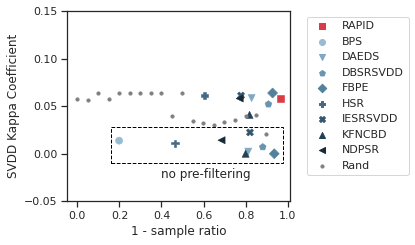

In [38]:
_, f = avg_plot('OutPerc(nothing)', metric='kappa')
plt.ylabel('SVDD Kappa Coefficient')
plt.yticks([-0.05, 0.0, 0.05, 0.1, 0.15])
f.axes.add_patch(Rectangle((0.16, -0.01), 0.82, 0.038, fill=False, linestyle='dashed', color='black'))
plt.text(0.4, -0.025, 'no pre-filtering')
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_kappa.pdf'), bbox_inches='tight')

#### F1 Score

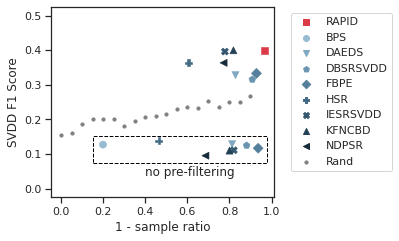

In [39]:
_, f = avg_plot('OutPerc(nothing)', metric='f1')
plt.ylabel('SVDD F1 Score')
plt.ylim([-0.025, 0.525]);
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
f.axes.add_patch(Rectangle((0.15, 0.075), 0.83, 0.077, fill=False, linestyle='dashed', color='black'))
plt.text(0.4, 0.037, 'no pre-filtering')
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_f1.pdf'), bbox_inches='tight')

#### ROC AUC

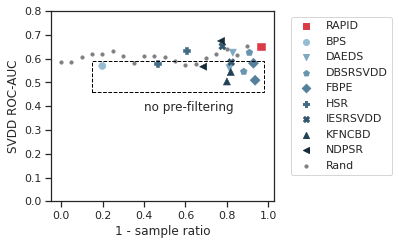

In [40]:
_, f = avg_plot('OutPerc(nothing)', metric='auc')
plt.ylabel('SVDD ROC-AUC')
plt.ylim([-0, 0.8])
f.axes.add_patch(Rectangle((0.15, 0.46), 0.83, 0.1315, fill=False, linestyle='dashed', color='black'))
plt.text(0.4, 0.38, 'no pre-filtering')
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_roc_auc.pdf'), bbox_inches='tight')

More details and statistical analysis of the ROC-AUC values

In [41]:
target_threshold_strat = 'OutPerc(nothing)'

competitors_sst = ['PP_BPS', 'PP_DAEDS', 'PP_DBSRSVDD', 'PP_FBPE', 'PP_HSR', 'PP_IESRSVDD', 'PP_KFNCBD', 'PP_NDPSR']
our_methods = [f'RAPID({target_threshold_strat})']

target_df = df.query('(sst in @competitors_sst or ss in @our_methods)').copy()

target_svdd_result = 'svdd_reinit_ROT_C1_mcc'.replace('mcc', 'auc')
target_svdd_result_baseline = 'svdd_reinit_ROT_CTax_mcc'.replace('mcc', 'auc')
target_svdd_result_ours = 'svdd_reinit_ROT_C1_mcc'.replace('mcc', 'auc')
target_df['t_pred_1k'] = target_df[target_svdd_result.replace('mcc', 'time_pred')] / target_df['n_observations'] * 1000
mask = target_df.query('ss in @our_methods').index

In [42]:
d = target_df.groupby(['data_set_name']).mean()[['n_observations', 'outlier_ratio']]
d.columns = pd.MultiIndex.from_tuples([('stats', 'size'), ('stats', 'out_p')])

for s in competitors_sst:
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]').groupby('data_set_name').median()[['sample_ratio', target_svdd_result, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    x.columns = pd.MultiIndex.from_tuples([(s, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')
for s in our_methods:
    x = target_df.query('ss == @s').groupby('data_set_name').median()[['sample_ratio', target_svdd_result_ours, 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['Rand(1.0)']:
    x = df_success.query('scenario == "dami_baseline_gt"').groupby('data_set_name').median()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Full'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

for s in ['HDS']:
    x = df_success.query('sst == @s and scenario == "dami_baseline_prefiltering"').groupby('data_set_name').median()[['sample_ratio', 'svdd_mcc', 'pwc_mcc']]
    x.columns = ['ratio', 'svdd', 'pwc']
    short_name = 'Prefilt'
    x.columns = pd.MultiIndex.from_tuples([(short_name, c) for c in x.columns])
    d = pd.merge(d, x, left_index=True, right_index=True, how='outer')

d_tests = []
for s in our_methods:
    t_col = ['data_set_name', 'fold', 'time_sampling', f'{target_svdd_result_ours[:-4]}_time_train', f'{target_svdd_result_ours[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result_ours[:-4]}_num_support_vectors', target_svdd_result_ours, 'pwc_mcc']
    x = target_df.query('ss == @s')[t_col].reset_index(drop=True)
    x.columns = ['data_set_name', 'fold', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s.split('(')[0] if not 'new' in s else f"{s.split('(')[0]}_new"
    d_tests.append(x[['data_set_name', 'fold', 'ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
for s in competitors_sst:
    t_col = ['data_set_name', 'fold', 'time_sampling', f'{target_svdd_result[:-4]}_time_train', f'{target_svdd_result[:-4]}_time_pred', 'sample_size', 'sample_ratio', f'{target_svdd_result[:-4]}_num_support_vectors', target_svdd_result, 'pwc_mcc']
    x = target_df.query('sst == @s and ss_threshold_strat in [@nan, @target_threshold_strat, "None"]')[t_col]
    x.columns = ['data_set_name', 'fold', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']
    x['ss'] = s
    d_tests.append(x[['data_set_name', 'fold', 'ss', 't_samp', 't_train', 't_pred', 'size', 'ratio', 'SVs', 'svdd', 'pwc']])
d_tests = pd.concat(d_tests).reset_index(drop=True)
d_tests.ss = d_tests.ss.str.replace('PP_', '')

In [43]:
mcc_mask = d.columns.get_level_values(1) == 'svdd'
d_highlight = d.iloc[:, mcc_mask].copy()
ranks = d_highlight.rank(axis=1, method='min', ascending=False, na_option='bottom')
d_highlight.loc['MEDIAN'] = d_highlight.median(skipna=False)
d_highlight.loc['AVG RANK'] = ranks.mean()
d_highlight.style.apply(highlight_max, axis=1)

,PP_BPS,PP_DAEDS,PP_DBSRSVDD,PP_FBPE,PP_HSR,PP_IESRSVDD,PP_KFNCBD,PP_NDPSR,RAPID,Full,Prefilt
,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd,svdd
data_set_name,,,,,,,,,,,
ALOI,nan,0.5164,0.5202,0.5193,0.5223,0.5165,0.5164,0.5198,0.5164,nan,nan
Annthyroid,0.4843,0.4902,0.5194,0.4910,0.4834,0.4853,0.4860,0.5017,0.4870,0.0205,-0.0179
Arrhythmia,0.7357,0.7362,0.7357,0.7372,0.7262,0.7357,0.7342,0.7357,0.7372,0.2900,0.3344
Cardiotocography,0.7764,0.7692,0.7971,0.7559,0.7748,0.7770,0.7712,0.7811,0.7779,0.1494,0.3428
Glass,0.2927,0.1707,0.2561,0.3537,0.3049,0.1220,0.1220,0.3902,0.2561,-0.0574,-0.0698
HeartDisease,0.6333,0.6250,0.4917,0.5806,0.6333,0.6347,0.4639,0.7056,0.6500,0.0791,0.2750
Hepatitis,0.7692,0.6923,0.7949,0.7436,0.7692,0.7692,0.2821,0.7692,0.7692,0.1816,0.1816
InternetAds,0.6761,0.5324,0.6438,0.5062,0.6274,0.6761,0.6012,0.6742,0.6769,0.1314,0.1290


In [44]:
stats = d_tests.groupby(['ss', 'data_set_name']).median().reset_index().groupby('ss').median()
stats.insert(3, 't_tot', stats[['t_samp', 't_train', 't_pred']].sum(axis=1))
stats = stats[['t_samp', 't_train', 't_pred', 'size', 'ratio', 'svdd']]
stats.round(2)
#print(stats.round(2).to_latex())

,t_samp,t_train,t_pred,size,ratio,svdd
ss,,,,,,
BPS,0.08,0.29,0.01,279.0,0.60,0.65
DAEDS,0.35,0.03,0.00,77.0,0.17,0.62
DBSRSVDD,0.01,0.02,0.00,35.0,0.09,0.63
FBPE,0.04,0.02,0.00,40.0,0.07,0.58
HSR,0.12,0.04,0.00,111.0,0.40,0.63
IESRSVDD,0.01,0.05,0.00,127.0,0.22,0.65
KFNCBD,0.27,0.03,0.00,80.0,0.18,0.54
NDPSR,0.04,0.04,0.00,87.0,0.23,0.67
RAPID,0.01,0.02,0.00,18.0,0.04,0.65


FriedmanchisquareResult(statistic=67.62589425929161, pvalue=1.456763366387627e-11)


,BPS,DAEDS,DBSRSVDD,FBPE,HSR,IESRSVDD,KFNCBD,NDPSR,RAPID
BPS,1.0000,0.0837,0.0784,0.0332,0.7662,0.7080,0.0010,0.9000,0.9000
DAEDS,0.0837,1.0000,0.9000,0.9000,0.9000,0.9000,0.6987,0.0062,0.2730
DBSRSVDD,0.0784,0.9000,1.0000,0.9000,0.9000,0.9000,0.7133,0.0057,0.2601
FBPE,0.0332,0.9000,0.9000,1.0000,0.7718,0.8300,0.8887,0.0018,0.1359
HSR,0.7662,0.9000,0.9000,0.7718,1.0000,0.9000,0.0612,0.2730,0.9000
IESRSVDD,0.7080,0.9000,0.9000,0.8300,0.9000,1.0000,0.0803,0.2243,0.9000
KFNCBD,0.0010,0.6987,0.7133,0.8887,0.0612,0.0803,1.0000,0.0010,0.0011
NDPSR,0.9000,0.0062,0.0057,0.0018,0.2730,0.2243,0.0010,1.0000,0.9000
RAPID,0.9000,0.2730,0.2601,0.1359,0.9000,0.9000,0.0011,0.9000,1.0000


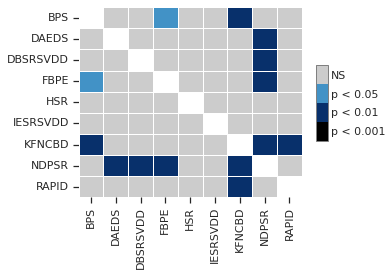

In [45]:
run_hyptest(d_tests, 'svdd', 'roc_auc_quality')

## Other outlier percentages for pre-filtering

We vary the outlier percentage by underestimating (5%) and overestimating (25%) it. The evaluation metric in the following is MCC.

Underestimation

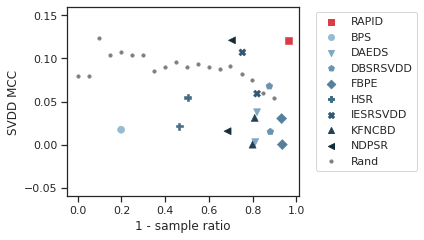

In [46]:
avg_plot('OutPerc(0.05)');
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_outperc_0.05.pdf'))
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_outperc_0.05.png'), dpi=300)

Overestimation

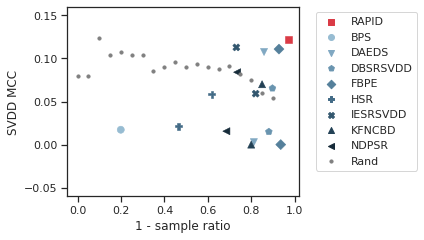

In [47]:
avg_plot('OutPerc(0.25)');
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_outperc_0.25.pdf'))
plt.savefig(os.path.join(PLOT_PATH, 'eval_avg_outperc_0.25.png'), dpi=300)